In [1]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from dotenv import load_dotenv
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from intervaltree import IntervalTree
import shutil

In [2]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

os.environ["WORKING_DIRECTORY"] = working_directory
os.environ["DATA_DIRECTORY"] = data_directory
os.environ["REFERENCES_DIRECTORY"] = references_directory
os.environ["RESULTS_DIRECTORY"] = results_directory
os.environ["UTILS_DIRECTORY"] = utils_directory

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

Loaded environment variables from: /home/lakishadavid/computational_genetic_genealogy/.env
Working Directory: /home/lakishadavid/computational_genetic_genealogy
Data Directory: /home/lakishadavid/computational_genetic_genealogy/data
References Directory: /home/lakishadavid/computational_genetic_genealogy/references
Results Directory: /home/lakishadavid/computational_genetic_genealogy/results
Utils Directory: /home/lakishadavid/computational_genetic_genealogy/utils
The current directory is /home/lakishadavid/computational_genetic_genealogy


In [3]:
def configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO"):
    """
    Configure logging for both file and console handlers.

    Args:
        log_filename (str): Path to the log file where logs will be written.
        log_file_debug_level (str): Logging level for the file handler.
        console_debug_level (str): Logging level for the console handler.
    """
    # Create a root logger
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)  # Capture all messages at the root level

    # Convert level names to numeric levels
    file_level = getattr(logging, log_file_debug_level.upper(), logging.INFO)
    console_level = getattr(logging, console_debug_level.upper(), logging.INFO)

    # File handler: Logs messages at file_level and above to the file
    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(file_level)
    file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(file_formatter)

    # Console handler: Logs messages at console_level and above to the console
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(console_level)
    console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(console_formatter)

    # Add handlers to the root logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
def clear_logger():
    """Remove all handlers from the root logger."""
    logger = logging.getLogger()
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
        
log_filename = os.path.join(results_directory, "lab8_log.txt")
print(f"The Lab 8 log file is located at {log_filename}.")

# Ensure the results_directory exists
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Check if the file exists; if not, create it
if not os.path.exists(log_filename):
    with open(log_filename, 'w') as file:
        pass  # The file is now created.
    
clear_logger() # Clear the logger before reconfiguring it
configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO")

The Lab 8 log file is located at /home/lakishadavid/computational_genetic_genealogy/results/lab8_log.txt.


### Prune the input vcf (real data)

In [ ]:
%%bash

# Define the input and output VCF files
input_vcf=${DATA_DIRECTORY}/class_data/merged_opensnps_data_autosomes.vcf.gz
output_vcf=${RESULTS_DIRECTORY}/merged_opensnps_data_autosomes_pruned

# Create directory in results directory - lab8_output
mkdir -p ${RESULTS_DIRECTORY}/lab8_output

echo "Input sample size:" $(bcftools query -l ${input_vcf} | wc -l)

# Step 1: Convert the VCF file to PLINK binary format (BED/BIM/FAM)
plink2 --vcf ${input_vcf} --make-bed --out dataset

# Step 2: Remove close relatives using a KING cutoff of 0.125.
# The threshold 0.125 corresponds roughly to the expected kinship coefficient for first cousins.
plink2 --bfile dataset --king-cutoff 0.125 --make-bed --out ${RESULTS_DIRECTORY}/lab8_output/dataset_unrelated

# Step 3: Convert the filtered, unrelated dataset back to VCF format
plink2 --bfile ${RESULTS_DIRECTORY}/lab8_output/dataset_unrelated --export vcf --out ${output_vcf}

# Step 4: Compress the VCF file using bgzip and index it using tabix
bgzip -c ${output_vcf}.vcf > ${output_vcf}.vcf.gz
tabix -p vcf ${output_vcf}.vcf.gz
rm ${output_vcf}.vcf

# Step 5: Use bcftools to report the sample size in both the output VCF files.
echo "######################################################################"
echo "Output sample size:" $(bcftools query -l ${output_vcf}.vcf.gz | wc -l)
echo "######################################################################"

# Remove all the intermediate files
rm ${RESULTS_DIRECTORY}/lab8_output/dataset_unrelated.bed
rm ${RESULTS_DIRECTORY}/lab8_output/dataset_unrelated.bim
rm ${RESULTS_DIRECTORY}/lab8_output/dataset_unrelated.fam
rm ${RESULTS_DIRECTORY}/lab8_output/dataset_unrelated.log
rm ${RESULTS_DIRECTORY}/lab8_output/dataset_unrelated.king.cutoff.in.id
rm ${RESULTS_DIRECTORY}/lab8_output/dataset_unrelated.king.cutoff.out.id

${RESULTS_DIRECTORY}/lab8_output/dataset.log

# make directory for the results
mkdir -p ${RESULTS_DIRECTORY}/ped_sim_run2_autosomes/unphased_samples

for chr in {1..22}; do
    
    plink2 --vcf ${output_vcf}.vcf.gz \
           --chr ${chr} \
           --export vcf bgz \
           --out ${RESULTS_DIRECTORY}/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_data_pruned_chr${chr}
done

### Phasing

In [ ]:
%%bash -s "$results_directory"

results_directory=$1

sample_file="merged_opensnps"
beagle="${UTILS_DIRECTORY}/beagle.17Dec24.224.jar"

# Create directories
mkdir -p "${results_directory}/ped_sim_run2_autosomes/phased_samples"

# Phase chromosomes using Beagle
for chr in {1..22}; do
    echo "Processing chromosome $chr"

    INPUT_VCF="${RESULTS_DIRECTORY}/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_data_pruned_chr${chr}.vcf.gz"
    REF_VCF="${REFERENCES_DIRECTORY}/onethousandgenomes_genotype_no_chr_prefix/subset_chr${chr}.vcf.gz"
    MAP_FILE="${REFERENCES_DIRECTORY}/genetic_maps/beagle_genetic_maps/plink.chr${chr}.GRCh38.map"
    OUTPUT_PREFIX="${results_directory}/ped_sim_run2_autosomes/phased_samples/merged_opensnps_data_pruned_chr${chr}"
    PHASED_VCF="${OUTPUT_PREFIX}.vcf.gz"
    TEMP_VCF="${results_directory}/ped_sim_run2_autosomes/phased_samples/temp_pruned_chr${chr}.vcf.gz"
    SORTED_VCF="${results_directory}/ped_sim_run2_autosomes/phased_samples/merged_opensnps_data_pruned_phased_chr${chr}_sorted.vcf.gz"

    # Check if input VCF exists
    if [ ! -f "$INPUT_VCF" ]; then
        echo "Input VCF file not found for chromosome $chr. Skipping."
        echo "$INPUT_VCF"
        continue
    fi

    # Run Beagle phasing
    if [ -f "$REF_VCF" ]; then
        echo "Running Beagle with reference panel for chromosome $chr"
        echo "$INPUT_VCF"
        java -jar ${beagle} \
            gt="$INPUT_VCF" \
            ref="$REF_VCF" \
            map="$MAP_FILE" \
            out="$OUTPUT_PREFIX" || {
                echo "Beagle failed for chromosome $chr. Skipping."
                continue
            }
    else
        echo "Running Beagle without reference panel for chromosome $chr"
        java -jar ${beagle} \
            gt="$INPUT_VCF" \
            map="$MAP_FILE" \
            out="$OUTPUT_PREFIX" || {
                echo "Beagle failed for chromosome $chr. Skipping."
                continue
            }
    fi

    if [ ! -f "$PHASED_VCF" ]; then
        echo "Phasing failed for chromosome $chr. Output file not found. Skipping."
        continue
    fi

    # Index the file
    tabix -f -p vcf "$PHASED_VCF"
    
    # Add INFO field definition and sort
    echo "Sorting VCF for chromosome $chr"
    bcftools annotate --header-lines <(echo '##INFO=<ID=END,Number=1,Type=Integer,Description="End position of the variant">') "$PHASED_VCF" | \
    bcftools sort -Oz -o "$SORTED_VCF" || {
        echo "Sorting failed for chromosome $chr"
        continue
    }

    # Index the sorted file
    tabix -f -p vcf "$SORTED_VCF"
    
    # If the sorted vcf and index exists, remove phased vcf and index
    if [ -f "$SORTED_VCF" ] && [ -f "$SORTED_VCF.tbi" ]; then
        rm -f "$PHASED_VCF"
        rm -f "$PHASED_VCF.tbi"
    fi
done

bcftools concat -Oz -o "${results_directory}/ped_sim_run2_autosomes/phased_samples/merged_opensnps_data_pruned_phased_all_sorted.vcf.gz" "${results_directory}/ped_sim_run2_autosomes/phased_samples/merged_opensnps_data_pruned_phased_chr"{1..22}"_sorted.vcf.gz"
tabix -f -p vcf "${results_directory}/ped_sim_run2_autosomes/phased_samples/merged_opensnps_data_pruned_phased_all_sorted.vcf.gz"

In [ ]:
%%bash

# Set up the references directory
references_directory="${REFERENCES_DIRECTORY}"
mkdir -p "$references_directory"

# Download the genetic map
wget https://github.com/cbherer/Bherer_etal_SexualDimorphismRecombination/raw/master/Refined_genetic_map_b37.tar.gz -P $references_directory
tar xvzf $references_directory/Refined_genetic_map_b37.tar.gz -C $references_directory

# Create the combined map file
printf "#chr\tpos\tmale_cM\tfemale_cM\n" > $references_directory/refined_mf_b37.simmap

# Process each chromosome
for chr in {1..22}; do
  paste $references_directory/Refined_genetic_map_b37/male_chr$chr.txt $references_directory/Refined_genetic_map_b37/female_chr$chr.txt \
    | awk -v OFS="\t" 'NR > 1 && $2 == $6 {print $1,$2,$4,$8}' \
    | sed 's/^chr//' >> $references_directory/refined_mf_b37.simmap
done

# Clean up the downloaded files
rm $references_directory/Refined_genetic_map_b37.tar.gz
rm -r $references_directory/Refined_genetic_map_b37

# Download the chain file for liftOver
wget -O "${references_directory}/hg19ToHg38.over.chain.gz" \
  "https://hgdownload.soe.ucsc.edu/goldenPath/hg19/liftOver/hg19ToHg38.over.chain.gz"

# Create a BED file from the build 37 simmap
awk 'NR>1 {print "chr"$1, $2-1, $2, $3, $4}' OFS="\t" $references_directory/refined_mf_b37.simmap > $references_directory/refined_mf_b37.bed

# Run liftOver to convert coordinates
liftOver $references_directory/refined_mf_b37.bed \
         $references_directory/hg19ToHg38.over.chain.gz \
         $references_directory/refined_mf_b38.bed \
         $references_directory/refined_mf_b38.unmapped

# Clean up temporary files
rm $references_directory/refined_mf_b37.bed

echo "✅ Genetic map successfully created at: $references_directory/refined_mf_b38.bed"
echo "This file contains the sex-specific genetic map in build 38 coordinates, ready for ped-sim."

### Simulate the seg and vcf data for the given genetic family tree

In [ ]:
def simulate_ground_truth():
    """Run ped-sim to simulate IBD segments based on pedigree definition"""
    vcf_file = f"{results_directory}/ped_sim_run2_autosomes/phased_samples/merged_opensnps_data_pruned_phased_all_sorted.vcf.gz"
    pedigree_def_file = f"{data_directory}/class_data/pedigree.def"
    refined_map = f"{references_directory}/refined_mf_b38.simmap"
    ped_sim_exec = f"{utils_directory}/ped-sim/ped-sim"
    interfere_file = f"{utils_directory}/ped-sim/interfere/nu_p_campbell.tsv"
    ped_sim_basename = "merged_opensnps_autosomes_ped_sim"
    output_prefix = f"{results_directory}/{ped_sim_basename}"
    
    # Run ped-sim
    print(f"Running ped-sim with input VCF {vcf_file}")
    cmd = [
        ped_sim_exec,
        "-d", pedigree_def_file,
        "-m", refined_map,
        "-o", output_prefix,
        "-i", vcf_file,
        "--intf", interfere_file,
        "--seed", "1234",
        "--fam",
        "--mrca"
    ]
    
    subprocess.run(cmd, check=True)
    
    # Check results
    if os.path.exists(f"{output_prefix}.seg") and os.path.exists(f"{output_prefix}.vcf.gz"):
        print(f"Truth segments file: {output_prefix}.seg")
        print(f"Simulated VCF file: {output_prefix}.vcf.gz")
        return f"{output_prefix}.vcf.gz", f"{output_prefix}.seg"

    else:
        print("ERROR: Ped-sim failed to generate output files")
        return None
    
simulated_vcf, simulated_seg = simulate_ground_truth()

# Preparing Data for IBD Detection Algorithms

## Overview
To accurately evaluate the performance of different IBD detection methods, we need to prepare the data in formats compatible with each algorithm. Each tool has specific input requirements that must be met.

## Algorithm Requirements
- **RefinedIBD**: Requires phased data, processes by chromosome
- **HapIBD**: Requires phased data, processes by chromosome
- **IBIS**: Can work with unphased data, can process all chromosomes together

## Preparation Steps

1. **Split by Chromosome**: The simulated VCF file contains data for all autosomes. We'll extract each chromosome separately to allow chromosome-by-chromosome processing.

2. **Quality Control**: For each chromosome, we apply standard QC filters:
   - Keep only biallelic SNPs
   - Remove exact duplicate variants
   - Filter variants on minor allele frequency (MAF > 0.05)
   - Remove variants with high missing data rates (< 5%)

3. **Phasing**: For RefinedIBD and HapIBD, we'll phase each chromosome separately using Beagle:
   - Use reference panels when available for improved phasing accuracy
   - Incorporate genetic maps for accurate recombination estimation
   - Add necessary INFO fields required by downstream tools

4. **Merging**: For IBIS, we'll merge all phased chromosomes back together into a single file

The output of this process includes:
- Chromosome-specific phased VCF files for RefinedIBD and HapIBD
- A merged phased VCF for IBIS
- File paths organized in a dictionary for subsequent analysis steps

To run the data preparation function:

```python
data_paths = prepare_data_for_ibd_detection(simulated_prefix)
```

### Check Genetic Maps

In [ ]:
def prepare_genetic_maps():
    """Prepare genetic maps for all IBD detection algorithms"""
    print("Preparing genetic maps for IBD detection algorithms...")
    
    # Create genetic maps directories
    beagle_map_dir = os.path.join(references_directory, "genetic_maps/beagle_genetic_maps")
    ibis_map_dir = os.path.join(references_directory, "genetic_maps/ibis_genetic_maps")
    os.makedirs(beagle_map_dir, exist_ok=True)
    os.makedirs(ibis_map_dir, exist_ok=True)
    
    # Check if we have Beagle maps already
    beagle_maps_exist = any(f.endswith(".map") for f in os.listdir(beagle_map_dir)) if os.path.exists(beagle_map_dir) else False
    
    # Download Beagle maps if needed
    if not beagle_maps_exist:
        print("Downloading Beagle genetic maps...")
        subprocess.run(
            f"poetry run python -m scripts_support.genetic_maps_download --data-source BEAGLE --assembly GRCh38",
            shell=True, check=True
        )
    
    # Convert Beagle maps to IBIS format
    print("Converting Beagle maps to IBIS format...")
    for map_file in os.listdir(beagle_map_dir):
        if map_file.endswith(".map"):
            beagle_map_filename = os.path.join(beagle_map_dir, map_file)
            ibis_map_filename = os.path.join(ibis_map_dir, map_file)
            
            # For IBIS maps, we need: CHR POSITION GENETIC_POSITION [RATE]
            # From Beagle maps which are: CHR . GENETIC_POSITION PHYSICAL_POSITION
            subprocess.run(
                f"awk '{{print $1, $4, $3, 0}}' {beagle_map_filename} > {ibis_map_filename}",
                shell=True, check=True
            )
    
    print("Genetic maps preparation complete.")
    return beagle_map_dir, ibis_map_dir

In [4]:
output_directory_unphased=f"{results_directory}/ped_sim_run2_autosomes/unphased_samples"
output_directory_phased=f"{results_directory}/ped_sim_run2_autosomes/phased_samples"

In [ ]:
# # debugging
# simulated_seg = "/home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim.seg"
# simulated_vcf = "/home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim.vcf.gz"
# simulated_vcf

'/home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim.vcf.gz'

### Quality Control

In [13]:
%%bash -s "$simulated_vcf" "$output_directory_unphased" "$output_directory_phased"

simulated_vcf="$1"
echo "simulated_vcf: ${simulated_vcf}"
output_directory_unphased="$2"
output_directory_phased="$3"

# Create a properly BGZF-compressed file from scratch
gunzip -c "$simulated_vcf" > "${simulated_vcf%.gz}.temp"
bgzip -c "${simulated_vcf%.gz}.temp" > "${simulated_vcf%.gz}.proper.gz"
rm "${simulated_vcf%.gz}.temp"  # Clean up the temp file
rm "${simulated_vcf}"
mv "${simulated_vcf%.gz}.proper.gz" "${simulated_vcf}"
# Now index the properly compressed file
tabix -p vcf "${simulated_vcf}"


# Get the base name of the VCF file
filename_wo_ext="${simulated_vcf%.vcf.gz}"
file_basename=$(basename "$filename_wo_ext")

# Run Quality Control (QC) on the VCF file
for chromosome in {1..22}; do
    echo "Processing chromosome $chromosome..."
    
    output_vcf="$output_directory_unphased/${file_basename}_qcfinished_chr${chromosome}.vcf.gz"
    
    # Extended QC pipeline:
    # 1. Select autosomal chromosome
    # 2. Keep only biallelic SNPs
    # -m2 keeps only variants with at least 2 alleles
    # -M2 keeps only variants with at most 2 alleles
    # could add: -i 'strlen(REF)=1 && strlen(ALT)=1' | \
    # 3. Remove exact duplicate variants
    # 4. Filter on MAF and missing data
    # 5. Sort variants
    bcftools view "$simulated_vcf" \
        --regions "${chromosome}" \
        --types snps \
        -m2 -M2 \
        -i 'strlen(REF)=1 && strlen(ALT)=1' | \
    bcftools norm --rm-dup exact | \
    bcftools view \
        -q 0.05:minor \
        -i 'F_MISSING < 0.05' | \
    bcftools sort -Oz -o "$output_vcf"
    
    # Index the final VCF with force flag
    bcftools index -f "$output_vcf"
    
    # Report number of variants
    # echo "Number of variants in chromosome $chromosome after QC:"
    bcftools index -n "$output_vcf"
    echo
done

beagle="${UTILS_DIRECTORY}/beagle.17Dec24.224.jar"

# Phase chromosomes using Beagle
for chr in {1..22}; do
    echo "Processing chromosome ${chr}"

    INPUT_VCF="${output_directory_unphased}/${file_basename}_qcfinished_chr${chr}.vcf.gz"
    REF_VCF="${REFERENCES_DIRECTORY}/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr${chr}.vcf.gz"
    MAP_FILE="${REFERENCES_DIRECTORY}/genetic_maps/beagle_genetic_maps/plink.chr${chr}.GRCh38.map"
    OUTPUT_PREFIX="${output_directory_phased}/${file_basename}_phased_chr${chr}_temp"
    PHASED_VCF="${OUTPUT_PREFIX}.vcf.gz"
    TEMP_VCF="${output_directory_phased}/temp_chr${chr}.vcf.gz"
    SORTED_VCF="${output_directory_phased}/${file_basename}_phased_chr${chr}.vcf.gz"

    # Check if input VCF exists
    if [ ! -f "${INPUT_VCF}" ]; then
        echo "Input VCF file not found for chromosome ${chr}. Skipping."
        echo "${INPUT_VCF}"
        continue
    fi

    # Run Beagle phasing
    if [ -f "${REF_VCF}" ]; then
        echo "Running Beagle with reference panel for chromosome ${chr}"
        java -jar ${beagle} \
            gt="${INPUT_VCF}" \
            ref="${REF_VCF}" \
            map="${MAP_FILE}" \
            out="${OUTPUT_PREFIX}" || {
                echo "Beagle failed for chromosome ${chr}. Skipping."
                continue
            }
    else
        echo "Running Beagle without reference panel for chromosome ${chr}"
        java -jar ${beagle} \
            gt="${INPUT_VCF}" \
            map="${MAP_FILE}" \
            out="${OUTPUT_PREFIX}" || {
                echo "Beagle failed for chromosome ${chr}. Skipping."
                continue
            }
    fi

    if [ ! -f "${PHASED_VCF}" ]; then
        echo "Phasing failed for chromosome ${chr}. Output file not found. Skipping."
        continue
    fi

    # Index the file
    tabix -f -p vcf "${PHASED_VCF}"
    
    # Add INFO field definition and sort
    echo "Sorting VCF for chromosome $CHR"
    bcftools annotate --header-lines <(echo '##INFO=<ID=END,Number=1,Type=Integer,Description="End position of the variant">') "${PHASED_VCF}" | \
    bcftools sort -Oz -o "${SORTED_VCF}" || {
        echo "Sorting failed for chromosome $CHR"
        continue
    }

    # Index the sorted file
    tabix -f -p vcf "${SORTED_VCF}"
    
    # If the sorted vcf and index exists, remove phased vcf and index
    if [ -f "${SORTED_VCF}" ] && [ -f "${SORTED_VCF}.tbi" ]; then
        rm -f "${PHASED_VCF}"
        rm -f "${PHASED_VCF}.tbi"
        rm -f "${PHASED_VCF}.log"
    fi
done

simulated_vcf: /home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim.vcf.gz
Processing chromosome 1...


Writing to /tmp/bcftools.DMRpUq
Lines   total/split/joined/realigned/skipped:	29944/0/0/0/0
Merging 1 temporary files
Cleaning
Done


29710

Processing chromosome 2...


Writing to /tmp/bcftools.LcOvE3
Lines   total/split/joined/realigned/skipped:	29929/0/0/0/0
Merging 1 temporary files
Cleaning
Done


29674

Processing chromosome 3...


Writing to /tmp/bcftools.toijRC
Lines   total/split/joined/realigned/skipped:	25047/0/0/0/0
Merging 1 temporary files
Cleaning
Done


24874

Processing chromosome 4...


Writing to /tmp/bcftools.zEjPkk
Lines   total/split/joined/realigned/skipped:	22237/0/0/0/0
Merging 1 temporary files
Cleaning
Done


22058

Processing chromosome 5...


Writing to /tmp/bcftools.HKxxNH
Lines   total/split/joined/realigned/skipped:	23127/0/0/0/0
Merging 1 temporary files
Cleaning
Done


22953

Processing chromosome 6...


Writing to /tmp/bcftools.1yTxvm
Lines   total/split/joined/realigned/skipped:	23719/0/0/0/0
Merging 1 temporary files
Cleaning
Done


23506

Processing chromosome 7...


Writing to /tmp/bcftools.LN4KOe
Lines   total/split/joined/realigned/skipped:	20559/0/0/0/0
Merging 1 temporary files
Cleaning
Done


20392

Processing chromosome 8...


Writing to /tmp/bcftools.EmxU0b
Lines   total/split/joined/realigned/skipped:	20385/0/0/0/0
Merging 1 temporary files
Cleaning
Done


20230

Processing chromosome 9...


Writing to /tmp/bcftools.SkHJnQ
Lines   total/split/joined/realigned/skipped:	18381/0/0/0/0
Merging 1 temporary files
Cleaning
Done


18249

Processing chromosome 10...


Writing to /tmp/bcftools.6jMZSP
Lines   total/split/joined/realigned/skipped:	20435/0/0/0/0
Merging 1 temporary files
Cleaning
Done


20270

Processing chromosome 11...


Writing to /tmp/bcftools.5HrhzL
Lines   total/split/joined/realigned/skipped:	18581/0/0/0/0
Merging 1 temporary files
Cleaning
Done


18435

Processing chromosome 12...


Writing to /tmp/bcftools.zS9woc
Lines   total/split/joined/realigned/skipped:	18940/0/0/0/0
Merging 1 temporary files
Cleaning
Done


18789

Processing chromosome 13...


Writing to /tmp/bcftools.cpngrF
Lines   total/split/joined/realigned/skipped:	14141/0/0/0/0
Merging 1 temporary files
Cleaning
Done


14046

Processing chromosome 14...


Writing to /tmp/bcftools.XWB2bW
Lines   total/split/joined/realigned/skipped:	12537/0/0/0/0
Merging 1 temporary files
Cleaning
Done


12432

Processing chromosome 15...


Writing to /tmp/bcftools.FXDWLd
Lines   total/split/joined/realigned/skipped:	11925/0/0/0/0
Merging 1 temporary files
Cleaning
Done


11850

Processing chromosome 16...


Writing to /tmp/bcftools.Oybmix
Lines   total/split/joined/realigned/skipped:	12832/0/0/0/0
Merging 1 temporary files
Cleaning
Done


12747

Processing chromosome 17...


Writing to /tmp/bcftools.1Yz0ko
Lines   total/split/joined/realigned/skipped:	11059/0/0/0/0
Merging 1 temporary files
Cleaning
Done


10978

Processing chromosome 18...


Writing to /tmp/bcftools.F7cMhX
Lines   total/split/joined/realigned/skipped:	11825/0/0/0/0
Merging 1 temporary files
Cleaning
Done


11737

Processing chromosome 19...


Writing to /tmp/bcftools.aULzI2
Lines   total/split/joined/realigned/skipped:	7840/0/0/0/0
Merging 1 temporary files
Cleaning
Done


7781

Processing chromosome 20...


Writing to /tmp/bcftools.lZlGgD
Lines   total/split/joined/realigned/skipped:	10415/0/0/0/0
Merging 1 temporary files
Cleaning
Done


10352

Processing chromosome 21...


Writing to /tmp/bcftools.s8M8xs
Lines   total/split/joined/realigned/skipped:	5862/0/0/0/0
Merging 1 temporary files
Cleaning
Done


5813

Processing chromosome 22...


Writing to /tmp/bcftools.1mwOK5
Lines   total/split/joined/realigned/skipped:	5764/0/0/0/0
Merging 1 temporary files
Cleaning
Done


5729

Processing chromosome 1
Running Beagle without reference panel for chromosome 1
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 07:28 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr1.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr1.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr1_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [1:817341-19301382]
Study     markers:                3,289

Burnin  iteration 1:           8 seconds
Burnin  iteration 2: 

Writing to /tmp/bcftools.1D8YCD
Merging 1 temporary files
Cleaning
Done


Processing chromosome 2
Running Beagle without reference panel for chromosome 2
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 07:33 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr2.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr2.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr2_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [2:130357-18028498]
Study     markers:                3,265

Burnin  iteration 1:           8 seconds
Burnin  iteration 2:       

Writing to /tmp/bcftools.Ybno1R
Merging 1 temporary files
Cleaning
Done


Processing chromosome 3
Running Beagle without reference panel for chromosome 3
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 07:38 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr3.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr3.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr3_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [3:67310-21595904]
Study     markers:                4,198

Burnin  iteration 1:           11 seconds
Burnin  iteration 2:       

Writing to /tmp/bcftools.oqla5U
Merging 1 temporary files
Cleaning
Done


Processing chromosome 4
Running Beagle without reference panel for chromosome 4
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 07:42 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr4.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr4.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr4_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [4:187687-22822398]
Study     markers:                3,433

Burnin  iteration 1:           9 seconds
Burnin  iteration 2:       

Writing to /tmp/bcftools.pLivfr
Merging 1 temporary files
Cleaning
Done


Processing chromosome 5
Running Beagle without reference panel for chromosome 5
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 07:46 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr5.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr5.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr5_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [5:163654-24851390]
Study     markers:                3,974

Burnin  iteration 1:           11 seconds
Burnin  iteration 2:      

Writing to /tmp/bcftools.41vFsz
Merging 1 temporary files
Cleaning
Done


Processing chromosome 6
Running Beagle without reference panel for chromosome 6
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 07:50 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr6.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr6.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr6_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [6:203878-21502446]
Study     markers:                4,247

Burnin  iteration 1:           13 seconds
Burnin  iteration 2:      

Writing to /tmp/bcftools.bpJRCY
Merging 1 temporary files
Cleaning
Done


Processing chromosome 7
Running Beagle without reference panel for chromosome 7
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 07:54 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr7.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr7.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr7_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [7:46239-22452771]
Study     markers:                4,204

Burnin  iteration 1:           11 seconds
Burnin  iteration 2:       

Writing to /tmp/bcftools.aHE5Ek
Merging 1 temporary files
Cleaning
Done


Processing chromosome 8
Running Beagle without reference panel for chromosome 8
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 07:58 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr8.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr8.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr8_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [8:214984-19079523]
Study     markers:                4,716

Burnin  iteration 1:           12 seconds
Burnin  iteration 2:      

Writing to /tmp/bcftools.c2NaAQ
Merging 1 temporary files
Cleaning
Done


Processing chromosome 9
Running Beagle without reference panel for chromosome 9
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:01 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr9.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr9.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr9_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [9:213149-19771892]
Study     markers:                4,668

Burnin  iteration 1:           15 seconds
Burnin  iteration 2:      

Writing to /tmp/bcftools.IHzWbV
Merging 1 temporary files
Cleaning
Done


Processing chromosome 10
Running Beagle without reference panel for chromosome 10
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:04 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr10.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr10.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr10_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [10:113006-18269869]
Study     markers:                4,214

Burnin  iteration 1:           14 seconds
Burnin  iteration 2:

Writing to /tmp/bcftools.iSBHeB
Merging 1 temporary files
Cleaning
Done


Processing chromosome 11
Running Beagle without reference panel for chromosome 11
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:08 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr11.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr11.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr11_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [11:242112-22689598]
Study     markers:                4,226

Burnin  iteration 1:           13 seconds
Burnin  iteration 2:

Writing to /tmp/bcftools.TRiE82
Merging 1 temporary files
Cleaning
Done


Processing chromosome 12
Running Beagle without reference panel for chromosome 12
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:11 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr12.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr12.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr12_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [12:82453-21998639]
Study     markers:                3,916

Burnin  iteration 1:           9 seconds
Burnin  iteration 2:  

Writing to /tmp/bcftools.Qjd4T7
Merging 1 temporary files
Cleaning
Done


Processing chromosome 13
Running Beagle without reference panel for chromosome 13
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:14 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr13.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr13.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr13_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [13:18706400-40350391]
Study     markers:                3,950

Burnin  iteration 1:           9 seconds
Burnin  iteration 2

Writing to /tmp/bcftools.CKPXzE
Merging 1 temporary files
Cleaning
Done


Processing chromosome 14
Running Beagle without reference panel for chromosome 14
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:17 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr14.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr14.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr14_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [14:18551346-41751717]
Study     markers:                3,438

Burnin  iteration 1:           8 seconds
Burnin  iteration 2

Writing to /tmp/bcftools.Nt4qqa
Merging 1 temporary files
Cleaning
Done


Processing chromosome 15
Running Beagle without reference panel for chromosome 15
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:19 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr15.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr15.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr15_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [15:19956119-32327926]
Study     markers:                1,435

Burnin  iteration 1:           6 seconds
Burnin  iteration 2

Writing to /tmp/bcftools.x1BNHe
Merging 1 temporary files
Cleaning
Done


Processing chromosome 16
Running Beagle without reference panel for chromosome 16
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:21 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr16.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr16.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr16_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [16:102222-19261586]
Study     markers:                3,586

Burnin  iteration 1:           11 seconds
Burnin  iteration 2:

Writing to /tmp/bcftools.Cytill
Merging 1 temporary files
Cleaning
Done


Processing chromosome 17
Running Beagle without reference panel for chromosome 17
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:24 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr17.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr17.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr17_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [17:163755-15106933]
Study     markers:                3,260

Burnin  iteration 1:           8 seconds
Burnin  iteration 2: 

Writing to /tmp/bcftools.8PKD8p
Merging 1 temporary files
Cleaning
Done


Processing chromosome 18
Running Beagle without reference panel for chromosome 18
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:26 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr18.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr18.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr18_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [18:112535-21568311]
Study     markers:                3,168

Burnin  iteration 1:           8 seconds
Burnin  iteration 2: 

Writing to /tmp/bcftools.eyjZ60
Merging 1 temporary files
Cleaning
Done


Processing chromosome 19
Running Beagle without reference panel for chromosome 19
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:29 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr19.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr19.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr19_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [19:267039-16089568]
Study     markers:                2,569

Burnin  iteration 1:           8 seconds
Burnin  iteration 2: 

Writing to /tmp/bcftools.VX9qzl
Merging 1 temporary files
Cleaning
Done


Processing chromosome 20
Running Beagle without reference panel for chromosome 20
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:30 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr20.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr20.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr20_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [20:88453-17059314]
Study     markers:                3,660

Burnin  iteration 1:           10 seconds
Burnin  iteration 2: 

Writing to /tmp/bcftools.86L7kM
Merging 1 temporary files
Cleaning
Done


Processing chromosome 21
Running Beagle without reference panel for chromosome 21
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:32 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr21.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr21.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr21_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [21:13297610-36615618]
Study     markers:                3,712

Burnin  iteration 1:           9 seconds
Burnin  iteration 2

Writing to /tmp/bcftools.UZOwUG
Merging 1 temporary files
Cleaning
Done


Processing chromosome 22
Running Beagle without reference panel for chromosome 22
beagle.17Dec24.224.jar (version 5.5)
Copyright (C) 2014-2024 Brian L. Browning
Enter "java -jar beagle.17Dec24.224.jar" to list command line argument
Start time: 08:33 PM CDT on 27 Apr 2025

Command line: java -Xmx1948m -jar beagle.17Dec24.224.jar
  gt=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/unphased_samples/merged_opensnps_autosomes_ped_sim_qcfinished_chr22.vcf.gz
  map=/home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr22.GRCh38.map
  out=/home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr22_temp
  nthreads=12

Reference samples:                    0
Study     samples:                  520

Window 1 [22:16613859-35645603]
Study     markers:                3,049

Burnin  iteration 1:           8 seconds
Burnin  iteration 2

Writing to /tmp/bcftools.e8qOhq
Merging 1 temporary files
Cleaning
Done


### Refined IBD

In [ ]:
%%bash -s "$simulated_vcf" "$output_directory_unphased" "$output_directory_phased"

simulated_vcf="$1"
output_directory_unphased="$2"
output_directory_phased="$3"
echo "output_directory_phased: ${output_directory_phased}"

# Get the base name of the VCF file
filename_wo_ext="${simulated_vcf%.vcf.gz}"
file_basename=$(basename "$filename_wo_ext")

# Define the Refined-IBD executable paths
refined_ibd="${UTILS_DIRECTORY}/refined-ibd.17Jan20.102.jar"
merge_ibd="${UTILS_DIRECTORY}/merge-ibd-segments.17Jan20.102.jar"

# Create directory for segments
mkdir -p "${RESULTS_DIRECTORY}/segments"

# Loop for multiple runs to enhance sensitivity
for run in {1..3}; do
    for chr in {1..22}; do
        phased_file="${output_directory_phased}/${file_basename}_phased_chr${chr}.vcf.gz"
        
        # Check if file exists
        if [[ ! -f "${phased_file}" ]]; then
            echo "Phased file not found for chr${chr}: ${phased_file}"
            continue
        fi
        
        echo "Processing chromosome ${chr}, run ${run} with RefinedIBD"
        
        # Run RefinedIBD
        java -jar "${refined_ibd}" \
            gt="${phased_file}" \
            map="${REFERENCES_DIRECTORY}/genetic_maps/beagle_genetic_maps/plink.chr${chr}.GRCh38.map" \
            lod=4 \
            length=3 \
            out="${RESULTS_DIRECTORY}/segments/temp_${file_basename}_refinedibd_chr${chr}_run${run}.seg" \
            nthreads=4
    done
done

gap_threshold=0.6
discord_threshold=1

for chr in {1..22}; do
    echo "🔀 Merging IBD segments for chr${chr}"
    phased_file="${output_directory_phased}/${file_basename}_phased_chr${chr}.vcf.gz"
    map_file="${REFERENCES_DIRECTORY}/genetic_maps/beagle_genetic_maps/plink.chr${chr}.GRCh38.map"
    merged_out="${RESULTS_DIRECTORY}/segments/${file_basename}_refinedibd_chr${chr}_merged.seg"

    # collect the .ibd.gz outputs from each run
    ibd_files=()
    for run in {1..3}; do
        prefix="${RESULTS_DIRECTORY}/segments/temp_${file_basename}_refinedibd_chr${chr}_run${run}.seg"
        f="${prefix}.ibd.gz"
        if [[ -f "$f" ]]; then
        ibd_files+=("$f")
        else
        echo "   ⚠️  Missing IBD file: $f"
        fi
    done

    if (( ${#ibd_files[@]} == 0 )); then
        echo "   ❌  No runs to merge for chr${chr}, skipping."
        continue
    fi

    # decompress & merge
    echo "   📦  Found ${#ibd_files[@]} runs; merging..."
    # process substitution avoids combining into one long string
    {
        for f in "${ibd_files[@]}"; do
        zcat "$f"
        done
    } | java -jar "${merge_ibd}" \
            "${phased_file}" \
            "${map_file}" \
            "${gap_threshold}" \
            "${discord_threshold}" \
        > "${merged_out}"

    echo "   ✅  Merged output written to ${merged_out}"
done

# Combine all per‐chromosome merge files into one final output
final_output="${RESULTS_DIRECTORY}/${file_basename}_refinedibd.seg"
> "${final_output}"   # truncate or create

for chr in {1..22}; do
    chr_merged="${RESULTS_DIRECTORY}/segments/${file_basename}_refinedibd_chr${chr}_merged.seg"
    if [[ -f "${chr_merged}" ]]; then
        cat "${chr_merged}" >> "${final_output}"
    else
        echo "⚠️  Missing merged file for chr${chr}: ${chr_merged}"
    fi
done

echo "✅  All chromosomes merged into: ${final_output}"

# 4. Clean up intermediate files
for chr in {1..22}; do
    for run in {1..3}; do
        rm -f "${RESULTS_DIRECTORY}/segments/temp_${file_basename}_refinedibd_chr${chr}_run${run}.seg.ibd.gz"
        rm -f "${RESULTS_DIRECTORY}/segments/temp_${file_basename}_refinedibd_chr${chr}_run${run}.seg.hbd.gz"
        rm -f "${RESULTS_DIRECTORY}/segments/temp_${file_basename}_refinedibd_chr${chr}_run${run}.seg.log"
    done
    rm -f "${RESULTS_DIRECTORY}/segments/${file_basename}_refinedibd_chr${chr}_merged.seg"
done

echo "🧹  Cleaned up all temporary segment files."

output_directory_phased: /home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples
🧹  Cleaned up all temporary segment files.


In [26]:
# Check RefinedIBD output
refined_ibd_output = os.path.join(results_directory, "merged_opensnps_autosomes_ped_sim_refinedibd.seg")
if os.path.exists(refined_ibd_output):
    print(f"RefinedIBD output found: {refined_ibd_output}")
    print(f"File size: {os.path.getsize(refined_ibd_output)} bytes")
else:
    print(f"RefinedIBD output not found: {refined_ibd_output}")

RefinedIBD output found: /home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim_refinedibd.seg
File size: 12633794 bytes


### HAP-IBD

In [32]:
%%bash -s "$simulated_vcf" "$output_directory_unphased" "$output_directory_phased"

simulated_vcf="$1"
output_directory_unphased="$2"
output_directory_phased="$3"
echo "output_directory_phased: ${output_directory_phased}"

# Get the base name of the VCF file
filename_wo_ext="${simulated_vcf%.vcf.gz}"
file_basename=$(basename "$filename_wo_ext")

# Define the Hap-IBD executable paths
hap_ibd="${UTILS_DIRECTORY}/hap-ibd.jar"

# Create directory for segments
mkdir -p "${RESULTS_DIRECTORY}/segments"

for chr in {1..22}; do
    phased_file="${output_directory_phased}/${file_basename}_phased_chr${chr}.vcf.gz"
    
    echo "Processing chromosome ${chr} with Hap IBD"
    
    # Run Hap IBD
    java -jar "${hap_ibd}" \
        gt="${phased_file}" \
        map="${REFERENCES_DIRECTORY}/genetic_maps/beagle_genetic_maps/plink.chr${chr}.GRCh38.map" \
        out="${RESULTS_DIRECTORY}/segments/${file_basename}_hapibd_chr${chr}.seg" \
        nthreads=4
done



# Combine all per‐chromosome merge files into one final output
final_output="${RESULTS_DIRECTORY}/${file_basename}_hapibd.seg"
> "${final_output}"   # truncate or create

for chr in {1..22}; do
    chr_merged="${RESULTS_DIRECTORY}/segments/${file_basename}_hapibd_chr${chr}.seg.ibd.gz"
    if [[ -f "${chr_merged}" ]]; then
        zcat "${chr_merged}" >> "${final_output}"
    else
        echo "⚠️  Missing merged file for chr${chr}: ${chr_merged}"
    fi
done

echo "✅  All chromosomes merged into: ${final_output}"

# 4. Clean up intermediate files
for run in {1..3}; do
    rm -f "${RESULTS_DIRECTORY}/segments/${file_basename}_hapibd_chr${chr}.seg.ibd.gz"
    rm -f "${RESULTS_DIRECTORY}/segments/${file_basename}_hapibd_chr${chr}.seg.hbd.gz"
    rm -f "${RESULTS_DIRECTORY}/segments/${file_basename}_hapibd_chr${chr}.seg.log"
done

echo "🧹  Cleaned up all temporary segment files."

output_directory_phased: /home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples
Processing chromosome 1 with Hap IBD
Copyright (C) 2019-2023 Brian L. Browning
Enter "java -jar hap-ibd.jar" to print a list of command line arguments

Program            :  hap-ibd.jar  [ version 1.0, 15Jun23.92f ]
Start Time         :  10:36 PM CDT on 27 Apr 2025
Max Memory         :  1948 MB

Parameters
  gt               :  /home/lakishadavid/computational_genetic_genealogy/results/ped_sim_run2_autosomes/phased_samples/merged_opensnps_autosomes_ped_sim_phased_chr1.vcf.gz
  map              :  /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr1.GRCh38.map
  out              :  /home/lakishadavid/computational_genetic_genealogy/results/segments/merged_opensnps_autosomes_ped_sim_hapibd_chr1.seg
  min-seed         :  2.0
  max-gap          :  1000
  min-extend       :  1.0
  min-output       :  2.0
  min-markers 

In [31]:
# Check HapIBD output
hap_ibd_output = os.path.join(results_directory, "merged_opensnps_autosomes_ped_sim_hapibd.seg")
if os.path.exists(hap_ibd_output):
    print(f"HapIBD output found: {hap_ibd_output}")
    print(f"File size: {os.path.getsize(hap_ibd_output)} bytes")
else:
    print(f"HapIBD output not found: {hap_ibd_output}")

HapIBD output found: /home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim_hapibd.seg
File size: 17495702 bytes


# Compare

In [34]:
prefix = "merged_opensnps_autosomes_ped_sim"

segments_pedsim = Path(results_directory) / f"{prefix}.seg"
segments_refinedibd = Path(results_directory) /f"{prefix}_refinedibd.seg"
segments_hapibd = Path(results_directory) / f"{prefix}_hapibd.seg"
segments_ibis = Path(results_directory) / f"{prefix}_ibis.seg"

segment_files = [segments_pedsim, segments_refinedibd, segments_hapibd, segments_ibis]

# Check if each file exists
missing_files = []
for file_path in segment_files:
    if not file_path.exists():
        print(f"Warning: File not found - {file_path}")
        missing_files.append(file_path.name)
    else:
        print(f"File exists: {file_path}")

# Provide instructions if files are missing
if missing_files:
    print("\nMissing segment files. To fix this issue:")
    print("1. Make sure you've run the corresponding IBD detection labs (Lab4-Lab7) first")
    print("2. Check the output directories in your results folder")
    print("3. For missing PedSim ground truth, try running cell 4 to copy it from the expected location")
    print("\nMissing files: " + ", ".join(missing_files))

File exists: /home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim.seg
File exists: /home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim_refinedibd.seg
File exists: /home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim_hapibd.seg

Missing segment files. To fix this issue:
1. Make sure you've run the corresponding IBD detection labs (Lab4-Lab7) first
2. Check the output directories in your results folder
3. For missing PedSim ground truth, try running cell 4 to copy it from the expected location

Missing files: merged_opensnps_autosomes_ped_sim_ibis.seg


In [36]:
files = [segments_pedsim, segments_refinedibd, segments_hapibd, segments_ibis]
# See head of each file
for file in files:
    if file.exists():
        print(f"Head of {file}:")
        with open(file, 'r') as f:
            for _ in range(5):
                print(f.readline().strip())
        print("\n")

Head of /home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim.seg:
FAM1_g1-b1-s1	FAM1_g2-b1-i1	1	817341	44617788	IBD1	0.000000	68.343071	68.343071
FAM1_g1-b1-s1	FAM1_g2-b1-i1	1	44617789	205983275	IBD1	68.343113	200.153155	131.810042
FAM1_g1-b1-s1	FAM1_g2-b1-i1	1	205983276	242249428	IBD1	200.153157	250.580913	50.427756
FAM1_g1-b1-s1	FAM1_g2-b1-i1	1	242249429	248876512	IBD1	250.580914	261.713366	11.132452
FAM1_g1-b1-s1	FAM1_g2-b1-i1	2	118913	4929466	IBD1	0.000000	8.741841	8.741841


Head of /home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim_refinedibd.seg:
FAM8_g6-b1-i1	0	FAM8_g6-b2-i1	0	1	817341	3775163	11.15	6.742
FAM8_g6-b1-i1	0	FAM8_g6-b2-i1	0	1	19978364	29416896	23.29	10.273
FAM8_g6-b1-i1	0	FAM8_g6-b2-i1	0	1	30024395	35186362	24.4	7.279
FAM8_g6-b1-i1	0	FAM8_g6-b2-i1	0	1	37473572	57447600	36.16	19.358
FAM8_g6-b1-i1	0	FAM8_g6-b2-i1	0	1	57915849	84900481	119.99	28.694


Head of /home/lakishadavid/computati

In [38]:
def load_refined_ibd(filepath):
    """Load Refined IBD output file"""
    try:
        df = pd.read_csv(filepath, sep="\t", header=None)
        df.columns = ["sample1", "sample1_haplotype", "sample2", 
                      "sample2_haplotype", "chrom", "start", "end", "LOD", "cM"]
        # Create a unique segment ID for each segment
        df['segment_id'] = range(len(df))
        df['tool'] = 'RefinedIBD'
        df['length'] = df['end'] - df['start']
        return df
    except Exception as e:
        print(f"Error loading Refined IBD file: {e}")
        cols = ["sample1", "sample1_haplotype", "sample2", "sample2_haplotype", 
                "chrom", "start", "end", "LOD", "cM"]
        return pd.DataFrame(columns=cols + ['segment_id', 'tool', 'length'])

def load_hap_ibd(filepath):
   """Load Hap IBD output file"""
   try:
       df = pd.read_csv(filepath, sep="\t", header=None)
       df.columns = ["sample1", "sample1_haplotype", "sample2", 
                     "sample2_haplotype", "chrom", "start", "end", "cM"]
       df['segment_id'] = range(len(df))
       df['tool'] = 'HapIBD'
       df['length'] = df['end'] - df['start']
       # Since LOD isn't in the HapIBD output, create a placeholder or use cM as proxy
       df['LOD'] = df['cM']  # Using cM as a proxy for confidence
       return df
   except Exception as e:
       print(f"Error loading Hap IBD file: {e}")
       cols = ["sample1", "sample1_haplotype", "sample2", "sample2_haplotype", 
               "chrom", "start", "end", "cM"]
       return pd.DataFrame(columns=cols + ['segment_id', 'tool', 'length', 'LOD'])

def load_ibis(filepath):
    """Load IBIS output file"""
    try:
        df = pd.read_csv(filepath, sep="\t", header=None)
        df.columns = ["sample1", "sample2", "chrom", 
                    "phys_start_pos", "phys_end_pos", 
                    "IBD_type", "genetic_start_pos", 
                    "genetic_end_pos", "genetic_seg_length", 
                    "marker_count", "error_count", "error_density"]
        
        # Map IBIS columns to standardized column names for evaluation
        df['start'] = df['phys_start_pos']
        df['end'] = df['phys_end_pos']
        df['cM'] = df['genetic_seg_length']
        df['segment_id'] = range(len(df))
        df['tool'] = 'IBIS'
        df['length'] = df['end'] - df['start']
        
        # Create LOD-like score based on error density (lower error = higher score)
        # Invert error_density to make higher values better
        df['LOD'] = 1.0 / (df['error_density'] + 0.001)  # Add small constant to avoid division by zero
        
        # Add haplotype columns if needed for consistent evaluation
        df['sample1_haplotype'] = 0  # Placeholder if IBIS doesn't specify haplotypes
        df['sample2_haplotype'] = 0
        
        return df
    except Exception as e:
        print(f"Error loading IBIS file: {e}")
        cols = ["sample1", "sample2", "chrom", "phys_start_pos", "phys_end_pos", 
                "IBD_type", "genetic_start_pos", "genetic_end_pos", "genetic_seg_length", 
                "marker_count", "error_count", "error_density"]
        return pd.DataFrame(columns=cols + ['start', 'end', 'segment_id', 'tool', 'length', 'LOD', 
                                           'sample1_haplotype', 'sample2_haplotype'])

def load_pedsim_truth(filepath):
   """Load ground truth IBD segments from ped-sim"""
   try:
       df = pd.read_csv(filepath, sep="\t", header=None)
       df.columns = ["id1", "id2", "chromosome", "physical_position_start", 
                    "physical_position_end", "IBD_type", "genetic_position_start", 
                    "genetic_position_end", "genetic_length"]
       
       # Map to standardized column names used in evaluation
       df['sample1'] = df['id1']
       df['sample2'] = df['id2']
       df['chrom'] = df['chromosome']
       df['start'] = df['physical_position_start']
       df['end'] = df['physical_position_end']
       df['cM'] = df['genetic_length']
       df['sample1_haplotype'] = 0  # Add placeholder haplotypes if needed
       df['sample2_haplotype'] = 0  # These can be updated if actual haplotype info exists
       
       df['segment_id'] = range(len(df))
       df['tool'] = 'Truth'
       df['length'] = df['end'] - df['start']
       return df
   except Exception as e:
       print(f"Error loading PedSim truth file: {e}")
       cols = ["id1", "id2", "chromosome", "physical_position_start", 
              "physical_position_end", "IBD_type", "genetic_position_start", 
              "genetic_position_end", "genetic_length"]
       return pd.DataFrame(columns=cols + ['sample1', 'sample2', 'chrom', 'start', 'end', 
                                         'cM', 'segment_id', 'tool', 'length',
                                         'sample1_haplotype', 'sample2_haplotype'])

In [39]:
refined_df = load_refined_ibd(segments_refinedibd)
hap_df = load_hap_ibd(segments_hapibd)
ibis_df = load_ibis(segments_ibis)
truth_df = load_pedsim_truth(segments_pedsim)

# Print data summaries
print(f"Loaded {len(refined_df)} Refined IBD segments")
print(f"Loaded {len(hap_df)} Hap IBD segments")
print(f"Loaded {len(ibis_df)} IBIS segments")
print(f"Loaded {len(truth_df)} truth segments from ped-sim")

Error loading IBIS file: [Errno 2] No such file or directory: '/home/lakishadavid/computational_genetic_genealogy/results/merged_opensnps_autosomes_ped_sim_ibis.seg'
Loaded 193023 Refined IBD segments
Loaded 294369 Hap IBD segments
Loaded 0 IBIS segments
Loaded 183061 truth segments from ped-sim


In [41]:
def create_interval_tree(truth_df):
    """Create an interval tree from truth segments for efficient overlap checking"""
    trees = {}
    
    print("Building interval trees from truth data...")
    
    # First try with standard column names
    if all(col in truth_df.columns for col in ['sample1', 'sample2', 'chrom', 'start', 'end']):
        sample1_col, sample2_col = 'sample1', 'sample2'
    # Then try with ped-sim column names
    elif all(col in truth_df.columns for col in ['id1', 'id2', 'chromosome', 'physical_position_start', 'physical_position_end']):
        sample1_col, sample2_col = 'id1', 'id2'
        # Map columns for consistency
        truth_df['sample1'] = truth_df['id1']
        truth_df['sample2'] = truth_df['id2']
        truth_df['chrom'] = truth_df['chromosome']
        truth_df['start'] = truth_df['physical_position_start']
        truth_df['end'] = truth_df['physical_position_end']
    else:
        print("Error: Could not identify required columns in truth data")
        return trees
    
    # Add haplotype columns if they don't exist
    if 'sample1_haplotype' not in truth_df.columns:
        truth_df['sample1_haplotype'] = 0
    if 'sample2_haplotype' not in truth_df.columns:
        truth_df['sample2_haplotype'] = 0
    
    # Create trees with and without haplotype information
    for _, row in truth_df.iterrows():
        # Create keys in both orders to handle either order in tool data
        pairs = [
            # With haplotypes
            ((row['sample1'], row['sample1_haplotype']), 
             (row['sample2'], row['sample2_haplotype']), 
             row['chrom']),
            ((row['sample2'], row['sample2_haplotype']), 
             (row['sample1'], row['sample1_haplotype']), 
             row['chrom']),
            # Without haplotypes
            ((row['sample1'], None), (row['sample2'], None), row['chrom']),
            ((row['sample2'], None), (row['sample1'], None), row['chrom'])
        ]
        
        for sample1, sample2, chrom in pairs:
            pair_key = (sample1, sample2)
            if (pair_key, chrom) not in trees:
                trees[(pair_key, chrom)] = IntervalTree()
            
            trees[(pair_key, chrom)].addi(row['start'], row['end'], row['segment_id'])
    
    print(f"Created {len(trees)} interval trees")
    return trees

def calculate_overlap(segment, tree):
    """Calculate overlap between a segment and truth segments in the tree"""
    overlaps = tree.overlap(segment['start'], segment['end'])
    if not overlaps:
        return 0, None
    
    # Find the best overlapping segment
    best_overlap = 0
    best_truth_id = None
    
    for interval in overlaps:
        overlap_start = max(segment['start'], interval.begin)
        overlap_end = min(segment['end'], interval.end)
        overlap_length = overlap_end - overlap_start
        
        if overlap_length > best_overlap:
            best_overlap = overlap_length
            best_truth_id = interval.data
    
    return best_overlap / (segment['end'] - segment['start']), best_truth_id

def evaluate_tool(tool_df, truth_trees):
    """Evaluate IBD detection performance for a specific tool"""
    # If the DataFrame is empty, return it without processing
    if len(tool_df) == 0:
        print(f"Tool: {tool_df.name if hasattr(tool_df, 'name') else 'Unknown'} - No segments to evaluate")
        return tool_df
        
    # Add columns for evaluation metrics
    tool_df['detected_truth'] = False
    tool_df['overlap_pct'] = 0.0
    tool_df['truth_id'] = None
    
    # Debug counters
    total_segments = len(tool_df)
    matched_segments = 0
    
    for idx, row in tool_df.iterrows():
        # Check if we have both sample pair in regular and reversed order
        sample_pairs = [
            # Regular order
            ((row['sample1'], row.get('sample1_haplotype', 0)), 
             (row['sample2'], row.get('sample2_haplotype', 0)),
             row['chrom']),
            # Reversed order
            ((row['sample2'], row.get('sample2_haplotype', 0)), 
             (row['sample1'], row.get('sample1_haplotype', 0)),
             row['chrom'])
        ]
        
        found_match = False
        for sample1, sample2, chrom in sample_pairs:
            pair_key = (sample1, sample2)
            if (pair_key, chrom) in truth_trees:
                overlap_pct, truth_id = calculate_overlap(row, truth_trees[(pair_key, chrom)])
                if overlap_pct > 0:
                    tool_df.at[idx, 'overlap_pct'] = overlap_pct
                    tool_df.at[idx, 'truth_id'] = truth_id
                    tool_df.at[idx, 'detected_truth'] = (overlap_pct >= 0.5)  # Consider >=50% overlap a true positive
                    matched_segments += 1 if overlap_pct >= 0.5 else 0
                    found_match = True
                    break
        
        # Try without haplotypes if no match found and haplotypes present
        if not found_match and 'sample1_haplotype' in row:
            # Create keys without haplotype information
            sample_pairs_no_hap = [
                ((row['sample1'], None), (row['sample2'], None), row['chrom']),
                ((row['sample2'], None), (row['sample1'], None), row['chrom'])
            ]
            
            for sample1, sample2, chrom in sample_pairs_no_hap:
                pair_key = (sample1, sample2)
                if (pair_key, chrom) in truth_trees:
                    overlap_pct, truth_id = calculate_overlap(row, truth_trees[(pair_key, chrom)])
                    if overlap_pct > 0:
                        tool_df.at[idx, 'overlap_pct'] = overlap_pct
                        tool_df.at[idx, 'truth_id'] = truth_id
                        tool_df.at[idx, 'detected_truth'] = (overlap_pct >= 0.5)
                        matched_segments += 1 if overlap_pct >= 0.5 else 0
                        break
    
    # Get the tool name safely
    tool_name = tool_df['tool'].iloc[0] if len(tool_df) > 0 else "Unknown"
    
    # Calculate percentage safely
    percentage = (matched_segments/total_segments*100) if total_segments > 0 else 0
    
    print(f"Tool: {tool_name} - Matched {matched_segments} of {total_segments} segments ({percentage:.2f}%)")
    return tool_df

def evaluate_all_tools(refined_df, hap_df, ibis_df, truth_df):
    """Evaluate all IBD detection tools"""
    # Create interval trees for truth segments
    truth_trees = create_interval_tree(truth_df)
    
    # Evaluate each tool
    refined_eval = evaluate_tool(refined_df, truth_trees)
    
    # Only evaluate tools with data
    if len(hap_df) > 0:
        hap_eval = evaluate_tool(hap_df, truth_trees)
    else:
        print("Tool: HapIBD - No segments to evaluate")
        hap_eval = hap_df.copy()
        hap_eval['tool'] = 'HapIBD'  # Ensure tool column exists
    
    ibis_eval = evaluate_tool(ibis_df, truth_trees)
    
    # Combine results
    all_results = pd.concat([refined_eval, hap_eval, ibis_eval], ignore_index=True)
    
    return all_results, truth_df

In [42]:
# Evaluate tools
print("Evaluating IBD detection tools...")
all_results, truth_df = evaluate_all_tools(refined_df, hap_df, ibis_df, truth_df)
print("Done!")

Evaluating IBD detection tools...
Building interval trees from truth data...
Created 292748 interval trees
Tool: RefinedIBD - Matched 178906 of 193023 segments (92.69%)
Tool: HapIBD - Matched 192770 of 294369 segments (65.49%)
Tool: Unknown - No segments to evaluate


/tmp/ipykernel_1273/1269812678.py:165: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([refined_eval, hap_eval, ibis_eval], ignore_index=True)


Done!


Generating visualizations...


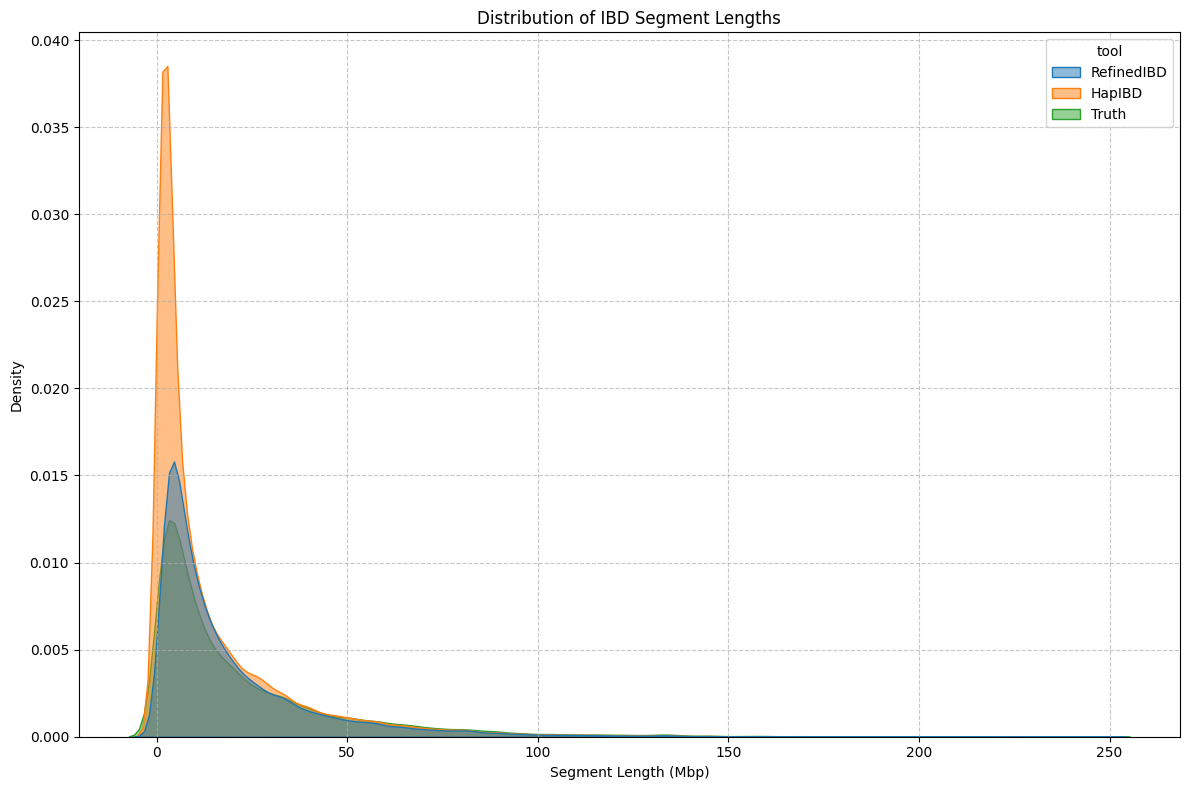

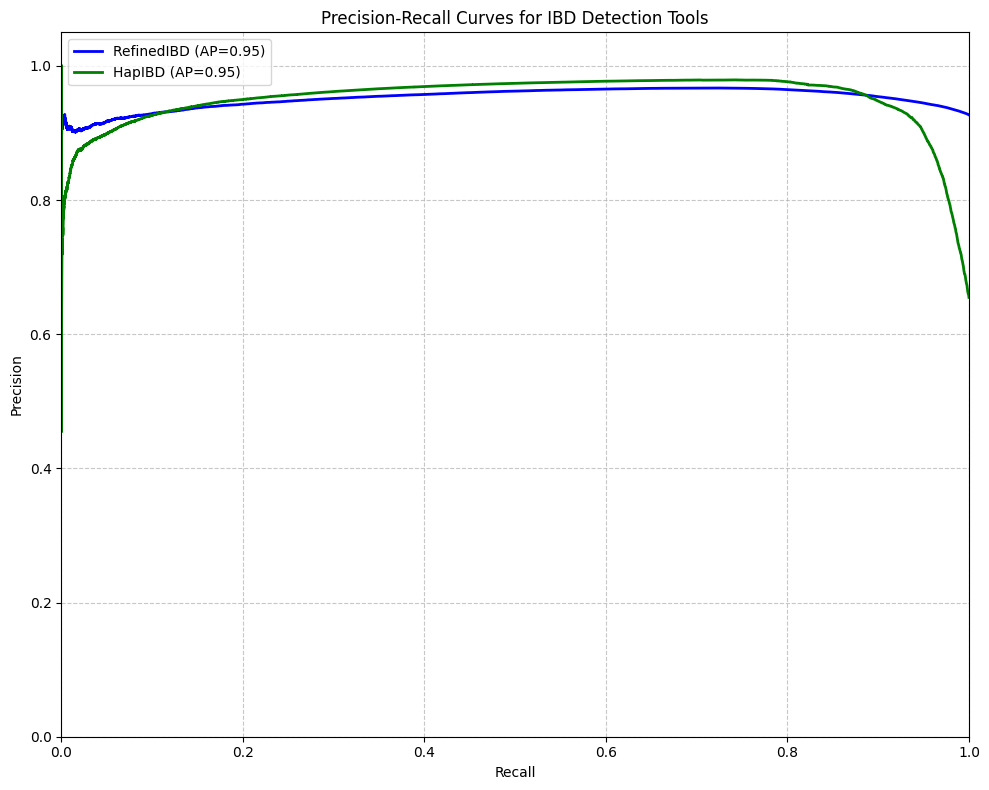

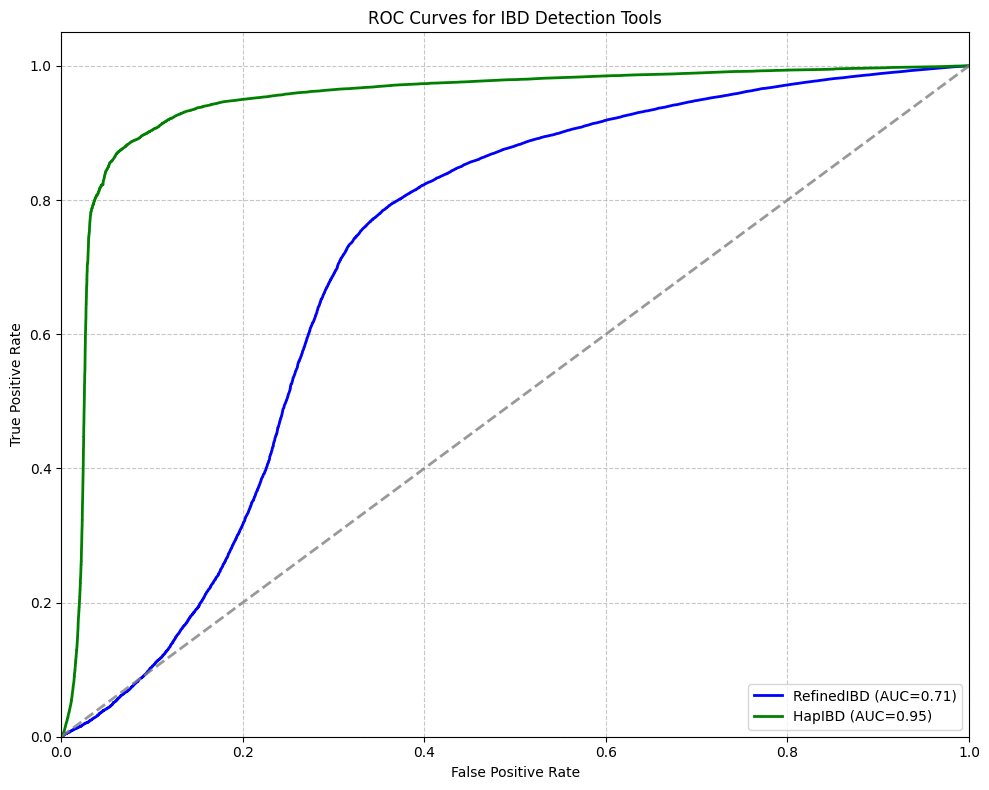

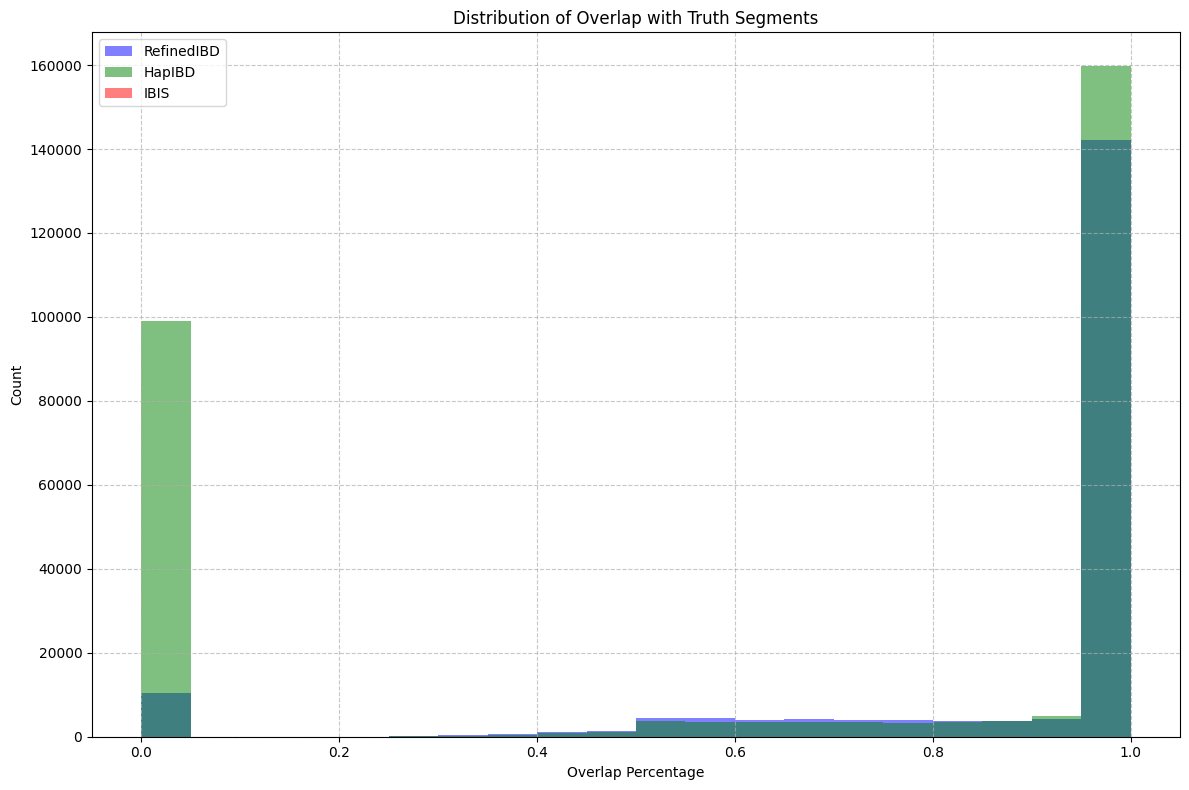

In [45]:
def plot_length_distribution(all_results, truth_df):
    """Plot the distribution of segment lengths for each tool and truth"""
    plt.figure(figsize=(12, 8))
    
    # Combine all data
    all_data = pd.concat([
        all_results[all_results['tool'] == 'RefinedIBD'][['length', 'tool']],
        all_results[all_results['tool'] == 'HapIBD'][['length', 'tool']],
        all_results[all_results['tool'] == 'IBIS'][['length', 'tool']],
        truth_df[['length', 'tool']]
    ])
    
    # Convert length from bp to Mbp
    all_data['length'] = all_data['length'] / 1_000_000
    
    # Plot density
    sns.kdeplot(data=all_data, x='length', hue='tool', fill=True, alpha=0.5)
    
    plt.title('Distribution of IBD Segment Lengths')
    plt.xlabel('Segment Length (Mbp)')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(Path(results_directory) / 'ibd_length_distribution.png')
    plt.show()

def plot_precision_recall(all_results, truth_df):
    """Plot precision-recall curves for each tool"""
    plt.figure(figsize=(10, 8))
    
    has_data = False
    # For each tool, calculate precision and recall using overlap percentage as score
    for tool_name, color in zip(['RefinedIBD', 'HapIBD', 'IBIS'], ['blue', 'green', 'red']):
        tool_df = all_results[all_results['tool'] == tool_name]
        
        # Skip if no data for this tool
        if len(tool_df) == 0:
            continue
            
        # Check if we have true positives
        if tool_df['detected_truth'].sum() == 0:
            print(f"Warning: No true positives found for {tool_name}, skipping PR curve")
            continue
            
        has_data = True
        
        if 'LOD' in tool_df.columns and not tool_df['LOD'].isna().all():
            score = tool_df['LOD']  # Use LOD score if available
        else:
            score = tool_df['length']  # Otherwise use length as a proxy for confidence
            
        y_true = tool_df['detected_truth'].astype(int)
        
        try:
            # Calculate precision and recall
            precision, recall, _ = precision_recall_curve(y_true, score)
            avg_precision = average_precision_score(y_true, score)
            
            # Plot PR curve
            plt.plot(recall, precision, lw=2, color=color,
                     label=f'{tool_name} (AP={avg_precision:.2f})')
        except Exception as e:
            print(f"Error plotting PR curve for {tool_name}: {e}")
    
    if has_data:
        plt.title('Precision-Recall Curves for IBD Detection Tools')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.savefig(Path(results_directory) / 'ibd_precision_recall.png')
        plt.show()
    else:
        print("Skipping PR curve plot: No valid data")

def plot_roc_curves(all_results, truth_df):
    """Plot ROC curves for each tool"""
    plt.figure(figsize=(10, 8))
    
    has_data = False
    # For each tool, calculate ROC using overlap percentage as score
    for tool_name, color in zip(['RefinedIBD', 'HapIBD', 'IBIS'], ['blue', 'green', 'red']):
        tool_df = all_results[all_results['tool'] == tool_name]
        
        # Skip if no data for this tool
        if len(tool_df) == 0:
            continue
            
        # Check if we have true positives
        if tool_df['detected_truth'].sum() == 0:
            print(f"Warning: No true positives found for {tool_name}, skipping ROC curve")
            continue
            
        has_data = True
        
        if 'LOD' in tool_df.columns and not tool_df['LOD'].isna().all():
            score = tool_df['LOD']  # Use LOD score if available
        else:
            score = tool_df['length']  # Otherwise use length as a proxy for confidence
            
        y_true = tool_df['detected_truth'].astype(int)
        
        try:
            # Calculate ROC
            fpr, tpr, _ = roc_curve(y_true, score)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, color=color,
                     label=f'{tool_name} (AUC={roc_auc:.2f})')
        except Exception as e:
            print(f"Error plotting ROC curve for {tool_name}: {e}")
    
    if has_data:
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8)
        plt.title('ROC Curves for IBD Detection Tools')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(Path(results_directory) / 'ibd_roc_curves.png')
        plt.show()
    else:
        print("Skipping ROC curve plot: No valid data")

def plot_overlap_histogram(all_results):
    """Plot histogram of overlap percentages for each tool"""
    plt.figure(figsize=(12, 8))
    
    for tool_name, color in zip(['RefinedIBD', 'HapIBD', 'IBIS'], ['blue', 'green', 'red']):
        tool_df = all_results[all_results['tool'] == tool_name]
        plt.hist(tool_df['overlap_pct'], bins=20, alpha=0.5, color=color, label=tool_name)
    
    plt.title('Distribution of Overlap with Truth Segments')
    plt.xlabel('Overlap Percentage')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(Path(results_directory) / 'ibd_overlap_histogram.png')
    plt.show()
    
# Generate visualizations
print("Generating visualizations...")
plot_length_distribution(all_results, truth_df)
plot_precision_recall(all_results, truth_df)
plot_roc_curves(all_results, truth_df)
plot_overlap_histogram(all_results)

In [46]:
def calculate_summary_metrics(all_results, truth_df):
    """Calculate summary statistics for each tool"""
    metrics = []
    
    # Count total truth segments
    total_truth = len(truth_df)
    print(f"Total truth segments: {total_truth}")
    
    for tool_name in ['RefinedIBD', 'HapIBD', 'IBIS']:
        tool_df = all_results[all_results['tool'] == tool_name]
        
        if len(tool_df) == 0:
            print(f"No segments found for {tool_name}, skipping metrics")
            continue
        
        # Count true positives (segments with >50% overlap)
        true_positives = tool_df['detected_truth'].sum()
        
        # Count false positives (segments with ≤50% overlap)
        false_positives = len(tool_df) - true_positives
        
        # Count truth segments detected by this tool
        detected_truth_ids = set([x for x in tool_df['truth_id'] if x is not None])
        detected_truths = len(detected_truth_ids)
        
        # Calculate recall (proportion of truth segments detected)
        recall = detected_truths / total_truth if total_truth > 0 else 0
        
        # Calculate precision (proportion of detected segments that are true)
        precision = true_positives / len(tool_df) if len(tool_df) > 0 else 0
        
        # Calculate F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Print detailed debug info
        print(f"\n{tool_name} Summary:")
        print(f"  Total segments: {len(tool_df)}")
        print(f"  True positives: {true_positives} ({true_positives/len(tool_df)*100:.2f}% of segments)")
        print(f"  False positives: {false_positives} ({false_positives/len(tool_df)*100:.2f}% of segments)")
        print(f"  Unique truth segments detected: {detected_truths} ({detected_truths/total_truth*100:.2f}% of truth)")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        
        metrics.append({
            'Tool': tool_name,
            'Total Segments': len(tool_df),
            'True Positives': true_positives,
            'False Positives': false_positives,
            'Detected Truth Segments': detected_truths,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Check if we have meaningful metrics
    if len(metrics_df) == 0 or metrics_df['True Positives'].sum() == 0:
        print("\n⚠️ WARNING: No true positives detected across any tool!")
        print("This suggests an issue with matching segments to ground truth.")
        print("Possible causes:")
        print("1. Column name mismatches between tool output and truth data")
        print("2. Sample ID format differences")
        print("3. Chromosome notation differences (e.g., 'chr1' vs '1')")
        print("4. Position coordinate system differences")
    
    return metrics_df

# Calculate and display summary metrics
print("Calculating summary metrics...")
metrics_df = calculate_summary_metrics(all_results, truth_df)
display(metrics_df)

Calculating summary metrics...
Total truth segments: 183061

RefinedIBD Summary:
  Total segments: 193023
  True positives: 178906 (92.69% of segments)
  False positives: 14117 (7.31% of segments)
  Unique truth segments detected: 126957 (69.35% of truth)
  Precision: 0.9269
  Recall: 0.6935
  F1 Score: 0.7934

HapIBD Summary:
  Total segments: 294369
  True positives: 192770 (65.49% of segments)
  False positives: 101599 (34.51% of segments)
  Unique truth segments detected: 142107 (77.63% of truth)
  Precision: 0.6549
  Recall: 0.7763
  F1 Score: 0.7104
No segments found for IBIS, skipping metrics


,Tool,Total Segments,True Positives,False Positives,Detected Truth Segments,Precision,Recall,F1 Score
0,RefinedIBD,193023,178906,14117,126957,0.926864,0.693523,0.793392
1,HapIBD,294369,192770,101599,142107,0.654858,0.776282,0.710419


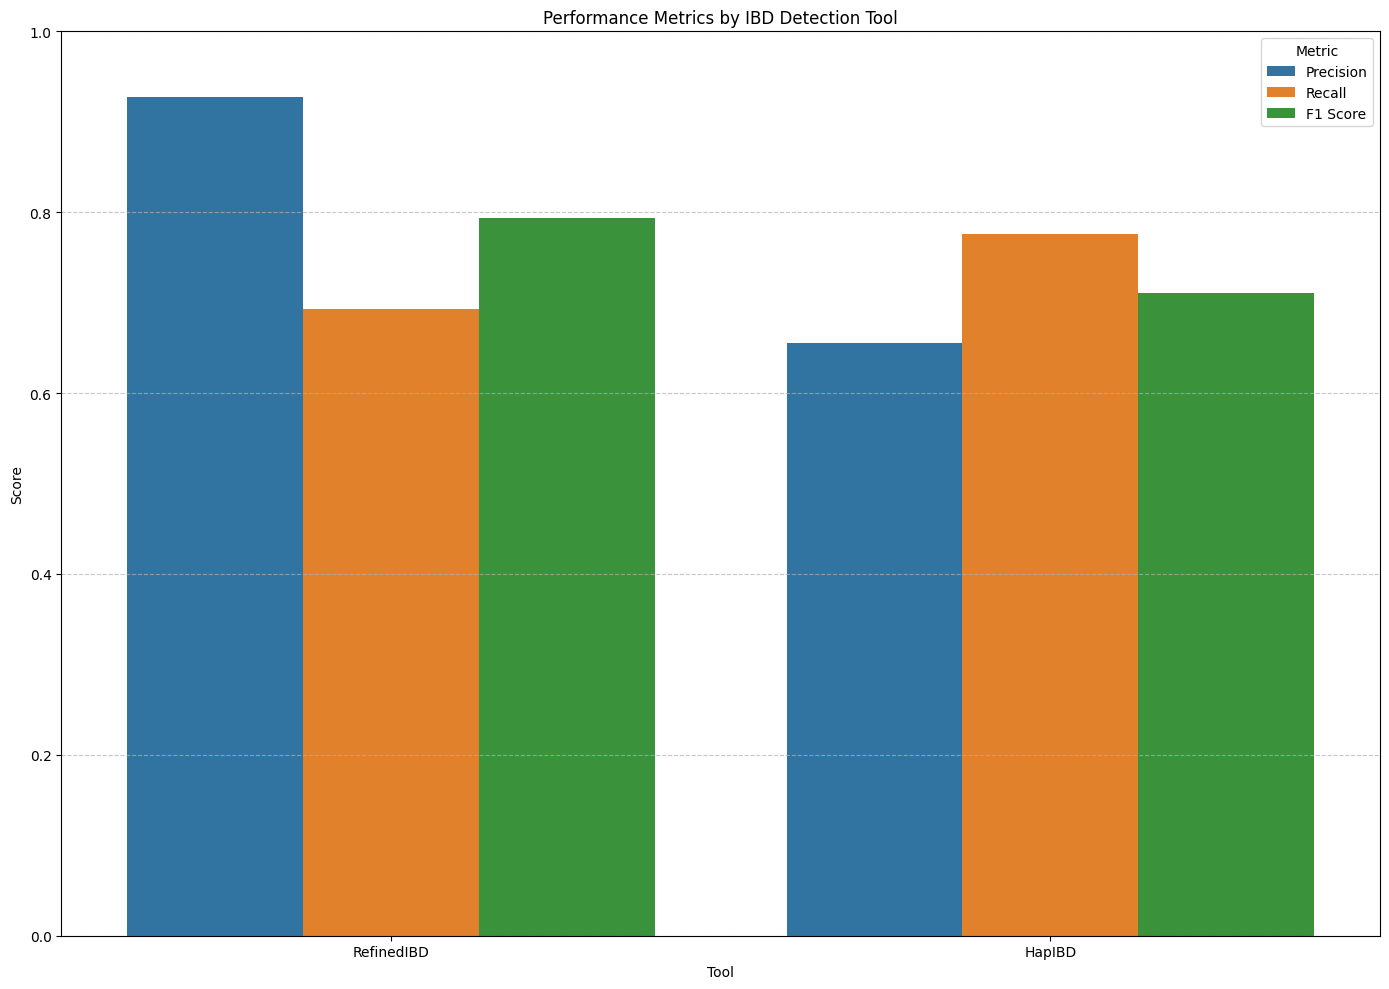

In [48]:
def plot_summary_barplot(metrics_df):
    """Plot summary metrics as a bar chart"""
    plt.figure(figsize=(14, 10))
    
    # Melt the dataframe to make it suitable for grouped bar chart
    plot_metrics = ['Precision', 'Recall', 'F1 Score']
    plot_df = pd.melt(metrics_df, id_vars=['Tool'], value_vars=plot_metrics, 
                      var_name='Metric', value_name='Value')
    
    # Create grouped bar chart
    sns.barplot(x='Tool', y='Value', hue='Metric', data=plot_df)
    
    plt.title('Performance Metrics by IBD Detection Tool')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.savefig(Path(results_directory) / 'ibd_performance_metrics.png')
    plt.show()
    
plot_summary_barplot(metrics_df)

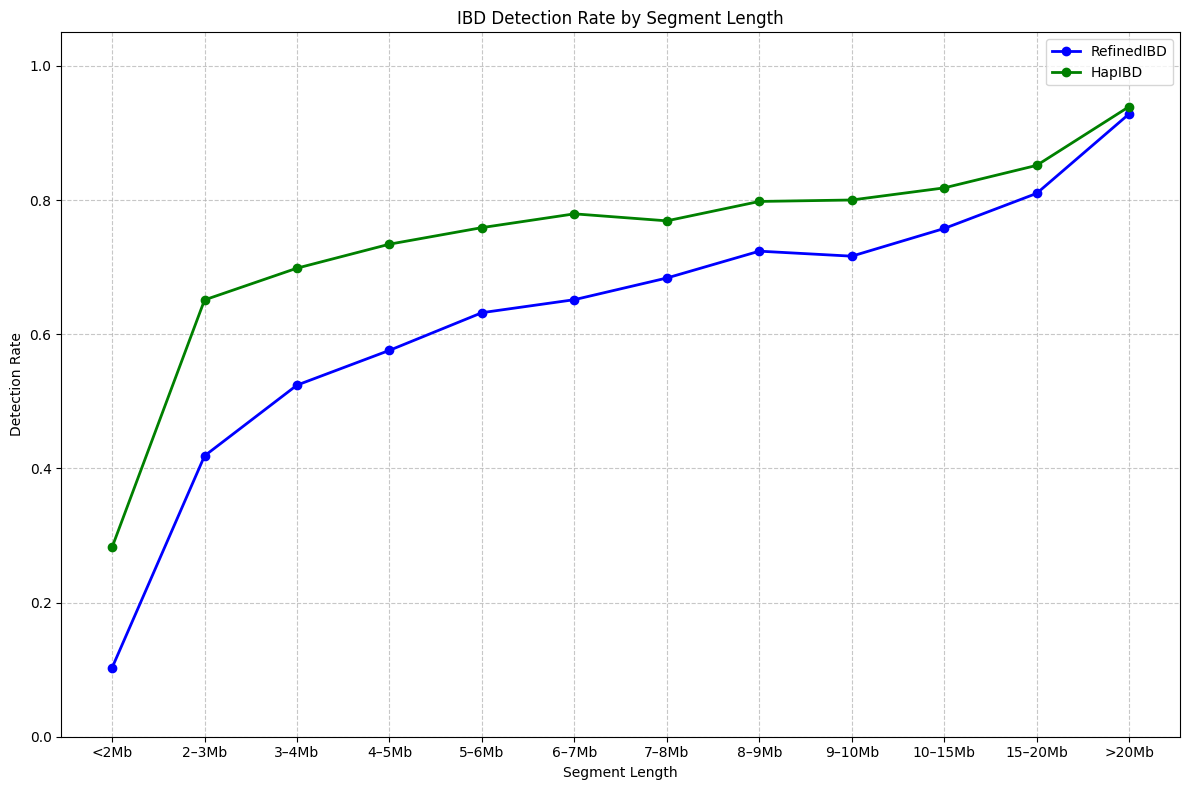

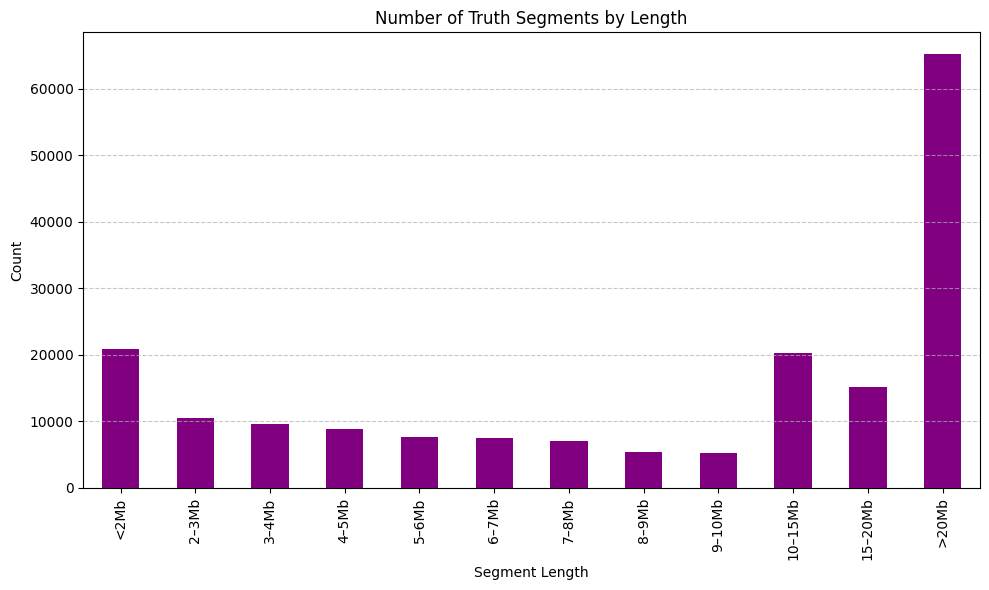

In [55]:
def plot_accuracy_by_length(all_results, truth_df, sample_size=None):
    """
    Plot detection accuracy as a function of segment length.
    
    Args:
        all_results: DataFrame with IBD detection results
        truth_df: DataFrame with ground truth segments
        sample_size: If provided, limit analysis to this many truth segments for faster execution
    """
    plt.figure(figsize=(12, 8))
    
    # Bin truth segments by length
    bins = [
        0,
        2e6,   # 2 Mb
        3e6,
        4e6,
        5e6,
        6e6,
        7e6,
        8e6,
        9e6,
        10e6,  # 10 Mb
        15e6,  # 15 Mb
        20e6,  # 20 Mb
        float('inf')
    ]
    bin_labels = [
        '<2Mb',
        '2–3Mb',
        '3–4Mb',
        '4–5Mb',
        '5–6Mb',
        '6–7Mb',
        '7–8Mb',
        '8–9Mb',
        '9–10Mb',
        '10–15Mb',
        '15–20Mb',
        '>20Mb'
    ]
    
    # Add length bins to truth dataframe
    truth_df['length_bin'] = pd.cut(truth_df['length'], bins=bins, labels=bin_labels)
    
    # Optionally sample the truth data for faster execution
    if sample_size is not None and len(truth_df) > sample_size:
        # Stratified sampling to maintain distribution across bins
        truth_df = truth_df.groupby('length_bin', observed=True).apply(
            lambda x: x.sample(min(len(x), max(1, int(sample_size * len(x) / len(truth_df)))))
        ).reset_index(drop=True)
        print(f"Using a stratified sample of {len(truth_df)} truth segments for faster execution")
    
    # Count total truth segments per bin
    truth_counts = truth_df.groupby('length_bin', observed=True).size()
    
    # For each tool, calculate detection rate by length bin using vectorized operations
    for tool_name, color in zip(['RefinedIBD', 'HapIBD', 'IBIS'], ['blue', 'green', 'red']):
        detection_rates = []
        
        # Get the tool's dataframe
        tool_df = all_results[all_results['tool'] == tool_name]
        if len(tool_df) == 0:
            continue
            
        # Create a set of truth_ids detected by this tool for faster lookup
        detected_truth_ids = set(tool_df['truth_id'].dropna())
        
        for bin_label in bin_labels:
            # Get truth segments in this bin
            bin_truth = truth_df[truth_df['length_bin'] == bin_label]
            total = len(bin_truth)
            
            if total == 0:
                detection_rates.append(0)
                continue
            
            # Count how many were detected by this tool - vectorized approach
            detected = sum(id in detected_truth_ids for id in bin_truth['segment_id'])
            detection_rates.append(detected / total if total > 0 else 0)
        
        plt.plot(bin_labels, detection_rates, marker='o', label=tool_name, color=color, linewidth=2)
    
    plt.title('IBD Detection Rate by Segment Length')
    plt.xlabel('Segment Length')
    plt.ylabel('Detection Rate')
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(Path(results_directory) / 'ibd_detection_by_length.png')
    plt.show()
    
    # Also create a bar chart showing segment counts by length
    plt.figure(figsize=(10, 6))
    truth_counts.plot(kind='bar', color='purple')
    plt.title('Number of Truth Segments by Length')
    plt.xlabel('Segment Length')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.savefig(Path(results_directory) / 'ibd_truth_segments_by_length.png')
    plt.show()

# Choose one of these calls:

# 1. Full analysis (takes ~76 minutes)
plot_accuracy_by_length(all_results, truth_df)

# 2. Faster version with sampling (takes ~5-10 minutes)
# plot_accuracy_by_length(all_results, truth_df, sample_size=50)

In [ ]:
# Attempt to convert this notebook to PDF using the Poetry environment
# Note: The notebook's CWD should be the project's base directory now.
print(f"Current directory for conversion: {os.getcwd()}")
notebook_path = "labs/Lab8_Evaluate_IBD_Detection.ipynb"

if Path(notebook_path).exists():
    print(f"Converting {notebook_path} to PDF...")
    !poetry run jupyter nbconvert --to pdf "{notebook_path}"
else:
    print(f"Error: Notebook not found at relative path {notebook_path} from CWD {os.getcwd()}")